In [166]:
import enum
import sys
import itertools
import bisect
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

In [2]:
Bateau = dict() # values are [nbr_case, valeur_pixel]
Bateau['porte_avions'] = [5, 10]
Bateau['croiseur'] = [4, 20]
Bateau['contre_torpilleurs'] = [3, 30]
Bateau['sous_marin'] = [3, 40]
Bateau['torpilleur'] = [2, 50]


class Direction(enum.Enum):
    horizontal = 1
    vertical = 2

In [12]:
isinstance(Direction.horizontal, Direction)

True

In [122]:
class Localisation():
    def __init__(self, pair_xy, direction, length):
        assert(isinstance(pair_xy, tuple) or isinstance(pair_xy, list))
        assert(len(pair_xy) == 2)
        assert(int(length) > 0)
        assert(isinstance(direction, Direction))
        
        self.pair_xy = pair_xy
        self.direction = direction
        self.length = length
        
    def equals(self, Loc2):
        assert(isinstance(Loc2, Localisation))
        return (self.pair_xy == Loc2.pair_xy and self.direction == Loc2.direction and self.length == Loc2.length)
    
    def __lt__(self, Loc2):
        """
            will be used by bisect.insort, to make the list of localisations sorted
        """
        return self.pair_xy < Loc2.pair_xy
    
    def __str__(self):
        s = "Localisation object: \n"
        s += "[+] coord: " + str(self.pair_xy) + '\n'
        s += "[+] direction: " + str(self.direction) +  " -> value: " + str(self.direction.value) + '\n'
        s += "[+] length of the ship: " + str(self.length) + '\n'
        
        return s

In [135]:
class Grille():
 
        
    def peut_placer(self, bateau, position, direction): # position is a tuple: (line, col)
        """
            @params: bateau -> str (key in Bateau dictionnary)
                     position -> tuple or list
                     direction -> Direction enum instance.
        """
        assert(bateau in Bateau)
        assert(len(position) == 2)
        assert(isinstance(direction, Direction))
        
        try:
            line = position[0]
            column = position[1]
            nbr_case = Bateau[bateau][0]

            if direction.value == Direction.horizontal.value:
                placement = self.grille[line, column:][:nbr_case]
                if sum(placement) == 0 and len(placement) == nbr_case:
                    return True
                return False

            elif direction.value == Direction.vertical.value:
                placement = self.grille[:, column][line:nbr_case + line]
                #print("placement %s => sum = %d", %(placement, sum(placement)))
                if sum(placement) == 0 and len(placement) == nbr_case:
                    return True
                return False

            else:
                raise ValueError("Direction doit etre soit vertical soit horizontal")
        except IndexError:
            return False
    
    def place(self, bateau, position, direction):
        # assertions will be done by peut_placer
        
        if self.peut_placer(bateau, position, direction):
            line = position[0]
            column = position[1]
            
            if direction.value == Direction.horizontal.value:
                self.grille[line, column:][:Bateau[bateau][0]] = Bateau[bateau][1]
            elif direction.value == Direction.vertical.value:
                self.grille[:, column][line:Bateau[bateau][0] + line] = Bateau[bateau][1]
            
            # using insort to keep the list sorted each insert (needed to compare 2 grids)
            bisect.insort(self.localisations, Localisation(list(position), direction, Bateau[bateau][0]))
            
            return True
            
        else:
            return False
            
    def place_alea(self, bateau):
        cols_list = list(range(self.cols))
        lines_list = list(range(self.lines))

        all_possible_positions = list(itertools.product(cols_list, lines_list)) # construct all possible pairs (coords)
        directions = [direction for direction in Direction]
        
        random_index = np.random.randint(len(all_possible_positions))
        random_direction = directions[np.random.randint(len(directions))] # returns a direction (type Direction enum)
        
        placed = self.place(bateau, all_possible_positions[random_index], random_direction)
        
        while not placed:
            del all_possible_positions[random_index] # sans remise
            
            random_index = np.random.randint(len(all_possible_positions))
            random_direction = directions[np.random.randint(len(directions))]
            placed = self.place(bateau, all_possible_positions[random_index], random_direction)
            
        bisect.insort(self.localisations, Localisation(list(all_possible_positions[random_index]), \
                                                       random_direction, Bateau[bateau][0]))
            
    def affiche(self):
        plt.imshow(self.grille)
        plt.set_cmap('hot')
        
    def eq(self, grilleB): # works only by constructions
        if (len(self.localisations) != len(grilleB.localisations)):
            return False
        
        for i in range(len(self.localisations)):
            if not self.localisations[i].equals(grilleB.localisations[i]):
                return False
        
        return True
    
    def genere_grille(self, h_many = 5):
        i = 0
        
        for bateau in Bateau:
            if i == h_many:
                break
                
            self.place_alea(bateau)
            i += 1
            
    def remove_ship(self, ship, position, direction):
        line = position[0]
        column = position[1]
        nbr_case = Bateau[ship][0]
        
        if direction.value == Direction.horizontal.value:
            self.grille[line, column:][:nbr_case] = 0
            
        elif direction.value == Direction.vertical.value:
            self.grille[:, column][line:nbr_case + line] = 0

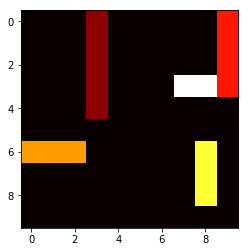

In [71]:
grille = Grille()
grille.genere_grille()
grille.affiche()

In [106]:
grid.place('torpilleur', (4, 7), Direction.horizontal)

True

In [107]:
grid.eq(grille)

False

## 2 Combinatoire du jeu

Donner une borne supérieure du nombre de configurations possibles pour la liste
complète de bateaux sur une grille de taille 10 (calcul à la main).

In [108]:
# fonction qui permet de dénombrer le nombre de façons de placer un bateau donné sur une grille vide
def how_many_ways_to_put(grid, ship_len, lines):
    """
        Assumption: the grid is represented as a SQUARE matrix
        
        @params: grid 
                 ship_len -> longueur du bateau 
                 lines -> number of lines in the grid
    """
    assert(isinstance(grid, Grille))
    assert(isinstance(ship_len, int) and ship_len > 0)
    
    #grid = Grille(lines, lines)
    count = 0
    Bateau['temp'] = [ship_len, 100]
    
    for i in range(lines):
        for j in range(lines):
            if grid.peut_placer('temp', (i,j), Direction.horizontal):
                count += 1
            
            if grid.peut_placer('temp', (i,j), Direction.vertical):
                count += 1
    
    del Bateau['temp']
    
    return count

In [109]:
def construct_ships(ships_length, colors=None):
    ships = []
    i = 0
    
    for ship_len in ships_length: 
        color = np.random.randint(10, 150)
        ship_name = str(ship_len + color) + 'D' + str(ships_length.count(ship_len))
        ships.append(ship_name)
        
        if colors is not None:
            Bateau[ship_name] = [ship_len, colors[i]]
            i += 1
        else:
            Bateau[ship_name] = [ship_len, color] 
    
    return ships

In [110]:
def calculate(grid, ships, lines, cols, count, visualize):    
    
    if len(ships) == 1:
        for i in range(lines):
            for j in range(cols):
                for direction in Direction:
                    if grid.peut_placer(ships[0], (i,j), direction):
                        
                        if visualize:
                            grid.place(ships[0], (i,j), direction)
                            grid.affiche()
                            show()
                            grid.remove_ship(ships[0], (i,j), direction)
                            
                        count += 1
                            
    else:
        for i in range(lines):
            for j in range(cols):
                for direction in Direction:
                    if grid.peut_placer(ships[0], (i,j), direction):
                        grid.place(ships[0], (i,j), direction)
                        count = calculate(grid, ships[1:], lines, cols, count, visualize)
                        
                        if count % 3 == 0:
                            sys.stdout.write("\r%d" % count)
                            sys.stdout.flush()
                        grid.remove_ship(ships[0], (i,j), direction)
                            
    return count

In [111]:
# fonction qui permet de dénombrer le nombre de façon de placer une liste de bateaux sur une grille vide. 
def how_many_conf(ships_length, lines, cols, visualize = False):
    grid = Grille(lines, cols)
    ships = construct_ships(ships_length)
    
    count = calculate(grid, ships, lines, cols, 0, visualize)
    
    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
        
    return count

In [112]:
how_many_conf([2, 3, 3], 10, 10)

3848040

3848040

In [219]:
def how_much_to_get_grid(grid):
    # fonction qui prend enparamètre une grille, génère des grilles aléatoirement jusqu’à ce que la grille 
    # générée soit égale à la grille passée en paramètre et qui renvoie le nombre de grilles générées.
    count = 1
    
    # constructing new ships with the same lengths and colors
    uniq, counts = (np.unique(grid.grille, return_counts=True))
    
    ships = dict(zip(uniq[1:], counts[1:]))
    ships = construct_ships(list(ships.values()), list(ships.keys()))
    
    # constructing new grids
    tmp = Grille(grid.lines, grid.cols)
    is_the_same = False
    
    for ship in ships:
        tmp.place_alea(ship)
        
    if tmp.eq(grid):
        is_the_same = True
        
    while not is_the_same:
        count += 1
        
        tmp = Grille(grid.lines, grid.cols)

        for ship in ships:
            tmp.place_alea(ship)

        if tmp.eq(grid):
            is_the_same = True
            
        if count % 3 == 0:
            sys.stdout.write("\r%d" % count)
            sys.stdout.flush()
    
    # deleting temp ships
    
    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
    
    return count

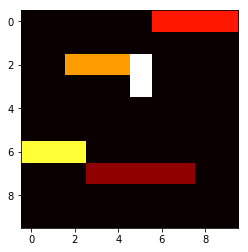

In [242]:
grid = Grille(10,10)
grid.genere_grille()
grid.affiche()

In [243]:
counts = []
for i in range(10):
    start = time.time()
    counts.append(how_much_to_get_grid(grid))
    print()
    end = time.time() - start
    print("time ", end)

45970884

KeyboardInterrupt: 

In [240]:
counts

[27, 7, 158, 16, 93, 11, 103, 86, 15, 32]